In [1]:
import time
import os
import numpy as np
import torch
import random

import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
CUDA = 'cuda:2'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
NUM_EPOCHS = 100
BATCH_SIZE = 128
NUM_WORKERS = 4 # workers for data loader

IMAGE_SIZE = (64, 64, 3)

# Size of the latent vector (gaussian noise)
LATENT_DIM = 100

# Number of feature maps in generator and discriminator
NUM_MAPS_GEN = 64
NUM_MAPS_DIS = 64

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [4]:
import os

num_train_cats = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('dog')])

print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

Training set cats: 12499
Training set dogs: 2501


(331, 464, 3)


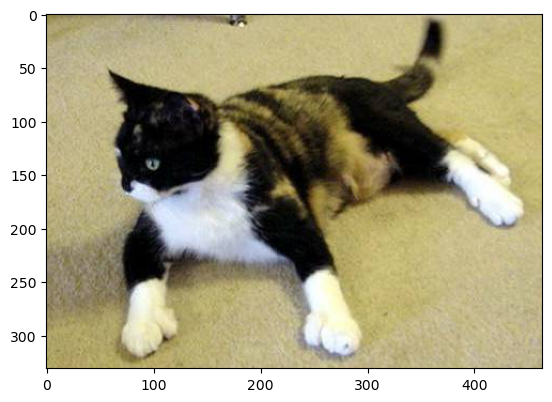

In [5]:
img = Image.open(os.path.join('dogs-vs-cats','train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

# Data loaders

In [6]:
class CatsDogsDataset(Dataset):
    """Custom Dataset for loading dogs-vs-cats images"""

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}


train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          num_workers=NUM_WORKERS,
                          shuffle=True)


In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))


# Model

In [ ]:
def weights_init(module):
    """
    Function that initializes weights according to
    DCGAN paper
    """
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [ ]:
##########################
### MODEL
##########################

class DCGAN(torch.nn.Module):

    def __init__(self):
        super(DCGAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            #
            # input size: vector z of size LATENT_DIM
            #
            nn.ConvTranspose2d(LATENT_DIM, NUM_MAPS_GEN*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False), # bias is redundant when using BatchNorm
            nn.BatchNorm2d(NUM_MAPS_GEN*8),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*8 x 4 x 4
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*8, NUM_MAPS_GEN*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*4),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*4 x 8 x 8
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*4, NUM_MAPS_GEN*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*2),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*2 x 16 x 16
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*2, NUM_MAPS_GEN, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN),
            nn.ReLU(True),   
            
            #
            # size: NUM_MAPS_GEN x 32 x 32
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN, IMAGE_SIZE[2], 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: IMAGE_SIZE[2] x 64 x 64
            #  
            nn.Tanh()
        )
        
    self.discriminator = nn.Sequential(
            #
            # input size IMAGE_SIZE[2] x IMAGE_SIZE[0] x IMAGE_SIZE[1]
            #
            nn.Conv2d(IMAGE_SIZE[2], NUM_MAPS_DIS,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS x 32 x 32
            #              
            nn.Conv2d(NUM_MAPS_DIS, NUM_MAPS_DIS*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*2 x 16 x 16
            #   
            nn.Conv2d(NUM_MAPS_DIS*2, NUM_MAPS_DIS*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*4 x 8 x 8
            #   
            nn.Conv2d(NUM_MAPS_DIS*4, NUM_MAPS_DIS*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*8 x 4 x 4
            #   
            nn.Conv2d(NUM_MAPS_DIS*8, 1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred

In [ ]:
torch.manual_seed(RANDOM_SEED)

loss_function = nn.BCELoss()

real_label = 1
fake_label = 0

# Batch of latent (noise) vectors for
# evaluating / visualizing the training progress
# of the generator
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=DEVICE)

model = DCGAN()
model = model.to(DEVICE)
model.apply(weights_init)

print(model)

In [1]:
from torchsummary import summary

# torchsummary can only use default cuda device, which
# causes issues if e.g., cuda:1 is used

with torch.cuda.device(int(CUDA.split(':')[-1])):
    summary(model.generator, input_size=(100, 1, 1), device='cuda')
    summary(model.discriminator, input_size=((IMAGE_SIZE[2], IMAGE_SIZE[0], IMAGE_SIZE[1])), device='cuda')

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
optim_gener = torch.optim.Adam(model.generator.parameters(),
                               betas=(0.5, 0.999),
                               lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

# training 

In [ ]:
start_time = time.time()    

discr_costs = []
gener_costs = []
images_from_noise = []


for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        optim_discr.zero_grad()
        
        real_images = features.to(DEVICE)
        num_real = real_images.size(0)
        real_label_vec = torch.full((num_real,), real_label, device=DEVICE)
        
        # get discriminator loss on real images
        discr_pred_real = model.discriminator_forward(real_images).view(-1)
        real_loss = loss_function(discr_pred_real, real_label_vec)
        #real_loss.backward()
        
        # get discriminator loss on fake images
        random_vec = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=DEVICE)
        fake_images = model.generator_forward(random_vec)
        fake_label_vec = torch.full((num_real,), fake_label, device=DEVICE)
        discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss = loss_function(discr_pred_fake, fake_label_vec)
        #fake_loss.backward()
                # combined loss
        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()

        optim_discr.step()        
  
        # --------------------------
        # Train Generator
        # --------------------------      

        optim_gener.zero_grad()        
        
        discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_function(discr_pred_fake, real_label_vec)
        gener_loss.backward()

        optim_gener.step()
        
        # --------------------------
        # Logging
        # --------------------------
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))
            
    ### Save images for evaluation
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        images_from_noise.append(
            vutils.make_grid(fake_images, padding=2, normalize=True))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))